# 导入需要用到的库

In [1]:
import os
import itertools

from string import Template
from collections import namedtuple
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image

import cupy as cp
import cupy
import numpy as np
import xml.etree.ElementTree as ET

import torch
import torch as t
from torch import nn
from torch.autograd import Function
from torch.nn import functional as F

from torchvision.models import vgg16
from skimage import transform as sktsf
from torchvision import transforms as tvtsf
from torchnet.meter import ConfusionMeter, AverageValueMeter

from model.utils.nms import non_maximum_suppression
from model.utils.roi_cupy import kernel_backward, kernel_forward
from utils import array_tool as at

D:\DataClinic\simple-faster-rcnn-pytorch\model\utils\nms\non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [2]:
%matplotlib notebook

# 配置文件

In [3]:
class Config:
    # data
    voc_data_dir = 'C:/Users/62307/Desktop/faster-rcnn-keras/VOCdevkit/VOC2007/'

    # sigma for l1_smooth_loss
    rpn_sigma = 3.
    roi_sigma = 1.

    weight_decay = 0.0005
    lr_decay = 0.1  # 1e-3 -> 1e-4
    lr = 1e-3

    # preset
    data = 'voc'
    pretrained_model = 'vgg16'

    # debug
    debug_file = '/tmp/debugf'
    
    def _parse(self, kwargs):
        state_dict = self._state_dict()
        for k, v in kwargs.items():
            if k not in state_dict:
                raise ValueError('UnKnown Option: "--%s"' % k)
            setattr(self, k, v)

        print('======user config========')
        print(self._state_dict())
        print('==========end============')

    def _state_dict(self):
        return {k: getattr(self, k) for k, _ in Config.__dict__.items() \
                if not k.startswith('_')}

opt = Config()

# 输入数据

## 数据输入时用到的工具

In [4]:
# 读取图片,值为[0-255]
# color模式：RGB彩色图片,通道数最前
def read_image(path):
    f = Image.open(path)
    img = f.convert('RGB')
    img = np.asarray(img, dtype=np.float32)
    # transpose (H, W, C) -> (C, H, W)
    return img.transpose((2, 0, 1))

In [5]:
# 函数preprocess实现对图像的预处理：
# 由read_image函数读入的图像为CHW的[0，255]格式，这里首先除以255，
# 把[0,1]的RGB正则化为均值为0,标准差为1的正态分布的RGB。
def preprocess(img):
    C, H, W = img.shape
    img = img / 255.
    normalize = tvtsf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(t.from_numpy(img))
    return img.numpy()

In [6]:
# 去正则化,用于输出原始图像。
def inverse_normalize(img):
    # approximate un-normalize for visualize
    return (img * 0.225 + 0.45).clip(min=0, max=1) * 255

## 建立输入数据库 

In [7]:
# 标签对应的名字。
BBOX_LABEL_NAMES = ('face')

In [8]:
# 读取VOC数据
# labels: (R,) R代表了一张图里真实物体的数量，值为0,1,2,...,代表前面那个元组里第几个元素。
class VOCBboxDataset:

    def __init__(self, data_dir):
        
        self.ids = list(range(1,65))
        self.data_dir = data_dir
        self.label_names = BBOX_LABEL_NAMES

    def __len__(self):
        return len(self.ids)

    def get_example(self, i):
        id_ = self.ids[i]
        anno = ET.parse(os.path.join(self.data_dir, 'Annotations', str(id_) + '.xml'))
        bbox = list()
        label = list()
        difficult = list()
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(BBOX_LABEL_NAMES.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)

        # Load a image
        img_file = os.path.join(self.data_dir, 'JPEGImages', str(id_) + '.jpg')
        img = read_image(img_file)

        return img, bbox, label

    __getitem__ = get_example

In [9]:
# 读取数据集
class Dataset:
    def __init__(self, opt):
        self.opt = opt
        self.db = VOCBboxDataset(opt.voc_data_dir)

    def __getitem__(self, idx):
        img, bbox, label = self.db.get_example(idx)
        img = preprocess(img)
        return img.copy(), bbox.copy(), label.copy()

    def __len__(self):
        return len(self.db)

In [10]:
# 这个函数用来看看一个样本的图形、bbox、对应的类别，和scale大小。
# 注意：只显示dataloader返回Batch的第一张图片。
def vis_train(img, bbox, label):
    # 因为Batchsize = 1, 所以可以这么些哦~
    
    img = inverse_normalize(img[0].numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))

    for i in range(len(bbox[0])):
        y1 = bbox[0][i][0]
        x1 = bbox[0][i][1]
        y2 = bbox[0][i][2]
        x2 = bbox[0][i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=2))
        ax.text(x1,y1,BBOX_LABEL_NAMES[label[0][i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

    return ax

# backbone网络

In [11]:
# 肢解VGG16网络，因为我们只用了其中的一部分。
# 返回前面的卷积层组，提取信息
# 和最后的分类全卷积层。
def decom_vgg16():
    # the 30th layer of features is relu of conv5_3
    model = vgg16(pretrained=False)

    features = list(model.features)[:30]
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6] #out=1000的全连接层
    del classifier[5] #Dropout层2
    del classifier[2] #Dropout层1
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False

    return nn.Sequential(*features), classifier

# Regional Proposal Network

## Anchors生成

In [12]:
# 这个函数的作用就是产生(0,0)坐标开始的基础的9个anchor框
# 分析一下函数的参数base_size=16就是基础的anchor的宽和高其实是16的大小
# 再根据不同的放缩比和宽高比进行进一步的调整
# ratios就是指的宽高的放缩比分别是0.5:1,1:1,1:2
# 最后一个参数是anchor_scales也就是在base_size的基础上再增加的量，
# 本代码中对应着三种面积的大小(16*8)^2 (16*16)^2 (16*32)^2  
# 也就是128,256,512的平方大小，三种面积乘以三种放缩比就刚刚好是9种anchor

def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    py = base_size / 2.
    px = base_size / 2.

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base

In [13]:
# 根据上面函数在0,0生成的anchor_base,在原图的特征图感受野左上角生成anchors
def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):

    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor

## Anchor Target Creator
生成Anchor的真实偏移量

In [14]:
# 计算哪些Anchor完全落在图片内部。
def _get_inside_index(anchor, H, W):
    index_inside = np.where(
        (anchor[:, 0] >= 0) & #y1
        (anchor[:, 1] >= 0) & #x1
        (anchor[:, 2] <= H) & #y2
        (anchor[:, 3] <= W)   #x2
    )[0]
    return index_inside

In [15]:
# 计算两个（a1,4）,（a2,4）形状bbox的所有iou
# 返回一个（a1,a2）形状的矩阵，
# 每i行，第j列代表第一个bbox列表的第i个box与第二个bbox列表第j个box的iou
def bbox_iou(bbox_a, bbox_b):
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError
    
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

In [16]:
# 计算以x,y,w,h形式的两个bbox之间的offset.
# src_bbox: anchor 所有的anchor
# dst_bbox: bbox[argmax_ious] 每个anchor对应iou最大的bbox
def bbox2loc(src_bbox, dst_bbox):

    # 真实的x,y,w,h
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width
    # anchor的x,y,w,h
    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width
    
    #考虑到除法的分母是不能为0的，而且式子中log内也不能为负数，不然会直接跳出显示错误。
    #eps开始的三行将可能出现的负数和零，使用eps来替换，这样就不会出现错误了。
    #finfo函数是根据height.dtype类型来获得信息，获得符合这个类型的float型，eps是取非负的最小值。
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc

In [17]:
# 把前面除掉的不完全在图片以内的anchors拿回来。
def _unmap(data, count, index, fill=0):

    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
        
    return ret

In [18]:
# 目的：利用每张图中bbox的真实标签来为所有任务分配ground truth！
# 输入：最初生成的20000个anchor坐标、此一张图中所有的bbox的真实坐标
# 输出：size为（20000，1）的正负label（其中只有128个为1，128个为0，其余都为-1
#       size为（20000，4）的回归目标（所有anchor的坐标都有）

# 将20000多个候选的anchor选出256个anchor进行二分类和所有的anchor进行回归位置 。为上面的预测值提供相应的真实值。选择方式如下：
# 对于每一个ground truth bounding box (gt_bbox)，选择和它重叠度（IoU）最高的一个anchor作为正样本。
# 对于剩下的anchor，从中选择和任意一个gt_bbox重叠度超过0.7的anchor，作为正样本，正样本的数目不超过128个。
# 随机选择和gt_bbox重叠度小于0.3的anchor作为负样本。负样本和正样本的总数为256。
# 对于每个anchor, gt_label 要么为1（前景），要么为0（背景），所以这样实现二分类。
# 在计算回归损失的时候，只计算正样本（前景）的损失，不计算负样本的位置损失。

class AnchorTargetCreator(object):

    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):

        img_H, img_W = img_size

        n_anchor = len(anchor)
        inside_index = _get_inside_index(anchor, img_H, img_W)
        anchor = anchor[inside_index]
        # argmax_ious [S,] 每个Anchor对应iou最大的bbox是第几个
        # label 每个Anchor是正样本(1)、负样本(0)还是忽略(-1)。
        argmax_ious, label = self._create_label(inside_index, anchor, bbox)

        # compute bounding box regression targets
        # 因为anchor还是x1y1x2y2的形式，转换成delta t形式
        # [R,4]
        loc = bbox2loc(anchor, bbox[argmax_ious])

        # map up to original set of anchors
        # 把不全在图里面的anchor恢复回来，label为-1，loc为0
        label = _unmap(label, n_anchor, inside_index, fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):
        # label: 1 is positive, 0 is negative, -1 is dont care
        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)
        # argmax_ious [S,] 每个Anchor对应iou最大的bbox是第几个
        # max_ious 每个anchor对应iou最大bbox的iou值
        # gt_argmax_ious 对于每一个(gt_bbox)，和它IoU最高的一个anchor的位置
        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox, inside_index)

        # assign negative labels first so that positive labels can clobber them
        # 如果每个anchor对应bbox的最大iou值都小于0.3,那么这就是负样本。
        label[max_ious < self.neg_iou_thresh] = 0

        # positive label: for each gt, anchor with highest iou
        # 每个bbox对应最大iou的那些anchor为正样本
        label[gt_argmax_ious] = 1

        # positive label: above threshold IOU
        # 每个anchor对应bbox的最大iou值都大于0.7,那么这也是正样本
        label[max_ious >= self.pos_iou_thresh] = 1

        # subsample positive labels if we have too many
        # 正样本不能太多
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # subsample negative labels if we have too many
        # 负样本也不能太多，正+负=256。正的不够128，负的来凑。
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label
    
    # 这个类内函数用来计算ious
    def _calc_ious(self, anchor, bbox, inside_index):
        # ious between the anchors and the gt boxes
        # [S,R] S个anchor,R个bbox
        ious = bbox_iou(anchor, bbox)
        # [S,] 每个Anchor对应iou最大的bbox是第几个
        argmax_ious = ious.argmax(axis=1)
        # 返回每个anchor对应iou最大bbox的iou值。
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        
        # [R,] 每个bbox对应iou最大的Anchor是第几个。
        gt_argmax_ious = ious.argmax(axis=0)
        # 返回每个bbox对应iou最大anchor的iou值
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        # 对于每一个(gt_bbox)，选择和它IoU最高的一个anchor作为正样本。
        # 正样本anchor的位置
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]
        
        return argmax_ious, max_ious, gt_argmax_ious

## Proposal Creator

RPN利用 AnchorTargetCreator自身训练的同时，还会提供RoIs（region of interests）给Fast RCNN（RoIHead）作为训练样本。RPN生成RoIs的过程(ProposalCreator)如下：

对于每张图片，利用它的feature map， 计算 (H/16)× (W/16)×9（大概20000）个anchor属于前景的概率，以及对应的位置参数。选取概率较大的12000个anchor利用回归的位置参数，修正这12000个anchor的位置，得到RoIs。

利用非极大值（(Non-maximum suppression, NMS）抑制，选出概率最大的2000个RoIs

注意：在inference的时候，为了提高处理速度，12000和2000分别变为6000和300.

注意：这部分的操作不需要进行反向传播，因此可以利用numpy/tensor实现。

RPN的输出：RoIs（形如2000×4或者300×4的tensor）

In [19]:
#把x,y,w,h转化回x1,y1,x2,y2的形式
def loc2bbox(src_bbox, loc):

    if src_bbox.shape[0] == 0:
        return xp.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox

In [20]:
# 目的：为Fast-RCNN也即检测网络提供2000个训练样本
# 输入：RPN网络中1*1卷积输出的loc和score，以及20000个anchor坐标，原图尺寸，scale（即对于这张训练图像较其原始大小的scale）
# 输出：2000个训练样本rois（只是2000*4的坐标，无ground truth！）
class ProposalCreator:

    def __init__(self,parent_model,nms_thresh=0.7,
                 n_train_pre_nms=12000,n_train_post_nms=2000,
                 n_test_pre_nms=6000,n_test_post_nms=300,
                 min_size=16):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score, anchor, img_size, scale=1.):

        # NOTE: when test, remember
        # faster_rcnn.eval()
        # to set self.traing = False
        if self.parent_model.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # Convert anchors into proposal via bbox transformations.
        roi = loc2bbox(anchor, loc)

        # Clip predicted boxes to image.
        # y小于图片高度
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        # x小于图片宽度
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

        # Remove predicted boxes with either height or width < threshold.
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN (e.g. 6000).
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]

        # Apply nms (e.g. threshold = 0.7).
        # Take after_nms_topN (e.g. 300).

        # unNOTE: somthing is wrong here!
        # TODO: remove cuda.to_gpu
        keep = non_maximum_suppression(cp.ascontiguousarray(cp.asarray(roi)), thresh=self.nms_thresh)
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi

## Proposal Target Creator
ProposalTargetCreator是RPN网络与ROIHead网络的过渡操作，前面讲过，RPN会产生大约2000个RoIs，这2000个RoIs不是都拿去训练，而是利用ProposalTargetCreator 选择128个RoIs用以训练。选择的规则如下：

RoIs和gt_bboxes 的IoU大于0.5的，选择一些（比如32个）
选择 RoIs和gt_bboxes的IoU小于等于0（或者0.1）的选择一些（比如 128-32=96个）作为负样本
为了便于训练，对选择出的128个RoIs，还对他们的gt_roi_loc 进行标准化处理（减去均值除以标准差）

对于分类问题,直接利用交叉熵损失. 而对于位置的回归损失,一样采用Smooth_L1Loss, 只不过只对正样本计算损失.而且是只对正样本中的这个类别4个参数计算损失。举例来说:

一个RoI在经过FC 84后会输出一个84维的loc 向量. 如果这个RoI是负样本,则这84维向量不参与计算 L1_Loss
如果这个RoI是正样本,属于label K,那么它的第 K×4, K×4+1 ，K×4+2， K×4+3 这4个数参与计算损失，其余的不参与计算损失。

In [21]:
# 目的：为2000个rois赋予ground truth！（严格讲挑出128个赋予ground truth！）
# 输入：2000个rois、一个batch（一张图）中所有的bbox ground truth（R，4）、对应bbox所包含的label（R，1）（VOC2007来说20类0-19）
# 输出：128个sample roi（128，4）、128个gt_roi_loc（128，4）、128个gt_roi_label（128，1）

class ProposalTargetCreator(object):

    def __init__(self,n_sample=128,
                 pos_ratio=0.25, pos_iou_thresh=0.5,
                 neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_hi = neg_iou_thresh_hi
        self.neg_iou_thresh_lo = neg_iou_thresh_lo  # NOTE:default 0.1 in py-faster-rcnn

    def __call__(self, roi, bbox, label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):

        n_bbox, _ = bbox.shape

        roi = np.concatenate((roi, bbox), axis=0)

        pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        iou = bbox_iou(roi, bbox)
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)
        # Offset range of classes from [0, n_fg_class - 1] to [1, n_fg_class].
        # The label with value 0 is the background.
        gt_roi_label = label[gt_assignment] + 1

        # Select foreground RoIs as those with >= pos_iou_thresh IoU.
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

        # Select background RoIs as those within
        # [neg_iou_thresh_lo, neg_iou_thresh_hi).
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) & (max_iou >= self.neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

        # The indices that we're selecting (both positive and negative).
        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels --> 0
        sample_roi = roi[keep_index]

        # Compute offsets and scales to match sampled RoIs to the GTs.
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32)) / np.array(loc_normalize_std, np.float32))

        return sample_roi, gt_roi_loc, gt_roi_label, keep_index

## Region Proposal Network

RPN网络的输入为图像特征。RPN网络是全卷积网络。RPN网络要完成的任务是训练自己、提供rois。

训练自己：二分类、bounding box 回归（由AnchorTargetCreator实现）

提供rois：为Fast-RCNN提供训练需要的rois（由ProposalCreator实现）

RPN网络流程我们之前介绍过一部分，这里完整的实现整个网络。

首先初始化网络的结构：特征（N，512，h，w）输入进来（原图像的大小：16*h，16*w），首先是加pad的512个3*3大小卷积核，输出仍为（N，512，h，w）。然后左右两边各有一个1*1卷积。左路为18个1*1卷积，输出为（N，18，h，w），即所有anchor的0-1类别概率（h*w约为2400，h*w*9约为20000）。右路为36个1*1卷积，输出为（N，36，h，w），即所有anchor的回归位置参数。

前向传播：输入特征即feature map，调用函数_enumerate_shifted_anchor生成全部20000个anchor。然后特征经过卷积，在经过两路卷积分别输出rpn_locs, rpn_scores。然后rpn_locs, rpn_scores作为ProposalCreator的输入产生2000个rois，同时还有 roi_indices，这个 roi_indices在此代码中是多余的，因为我们实现的是batch_siae=1的网络，一个batch只会输入一张图象。如果多张图象的话就需要存储索引以找到对应图像的roi。

In [22]:
# 用来为权重初始化
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

In [23]:
class RegionProposalNetwork(nn.Module):


    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            proposal_creator_params=dict(),
    ):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):

        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)

        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i].cpu().data.numpy(), rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size, scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        return rpn_locs, rpn_scores, rois, roi_indices, anchor

# Region of Interests Network

In [24]:
#这些代码是用来反向传播的应该。

Stream = namedtuple('Stream', ['ptr'])
CUDA_NUM_THREADS = 1024

@cupy.util.memoize(for_each_device=True)
def load_kernel(kernel_name, code, **kwargs):
    cp.cuda.runtime.free(0)
    code = Template(code).substitute(**kwargs)
    kernel_code = cupy.cuda.compile_with_cache(code)
    return kernel_code.get_function(kernel_name)

def GET_BLOCKS(N, K=CUDA_NUM_THREADS):
    return (N + K - 1) // K

## ROI Pooling 

In [25]:
# 有些没看懂
class RoI(Function):
    def __init__(self, outh, outw, spatial_scale):
        self.forward_fn = load_kernel('roi_forward', kernel_forward)
        self.backward_fn = load_kernel('roi_backward', kernel_backward)
        self.outh, self.outw, self.spatial_scale = outh, outw, spatial_scale

    def forward(self, x, rois):
        # NOTE: MAKE SURE input is contiguous too
        x = x.contiguous()
        rois = rois.contiguous()
        self.in_size = B, C, H, W = x.size()
        self.N = N = rois.size(0)
        output = t.zeros(N, C, self.outh, self.outw).cuda()
        self.argmax_data = t.zeros(N, C, self.outh, self.outw).int().cuda()
        self.rois = rois
        args = [x.data_ptr(), rois.data_ptr(),
                output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.spatial_scale, C, H, W,
                self.outh, self.outw,
                output.numel()]
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        self.forward_fn(args=args,
                        block=(CUDA_NUM_THREADS, 1, 1),
                        grid=(GET_BLOCKS(output.numel()), 1, 1),
                        stream=stream)
        return output

    def backward(self, grad_output):
        ##NOTE: IMPORTANT CONTIGUOUS
        # TODO: input
        grad_output = grad_output.contiguous()
        B, C, H, W = self.in_size
        grad_input = t.zeros(self.in_size).cuda()
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        args = [grad_output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.rois.data_ptr(),
                grad_input.data_ptr(),
                self.N, self.spatial_scale, C, H, W, self.outh, self.outw,
                grad_input.numel()]
        self.backward_fn(args=args,
                         block=(CUDA_NUM_THREADS, 1, 1),
                         grid=(GET_BLOCKS(grad_input.numel()), 1, 1),
                         stream=stream
                         )
        return grad_input, None




In [26]:
class RoIPooling2D(t.nn.Module):

    def __init__(self, outh, outw, spatial_scale):
        super(RoIPooling2D, self).__init__()
        self.RoI = RoI(outh, outw, spatial_scale)

    def forward(self, x, rois):
        return self.RoI(x, rois)

In [27]:
class VGG16RoIHead(nn.Module):

    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        # n_class includes the background
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = RoIPooling2D(self.roi_size, self.roi_size, self.spatial_scale)

    def forward(self, x, rois, roi_indices):

        # in case roi_indices is  ndarray
        roi_indices = at.totensor(roi_indices).float()
        rois = at.totensor(rois).float()
        indices_and_rois = t.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous()

        pool = self.roi(x, indices_and_rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        
        return roi_cls_locs, roi_scores

# Faster RCNN

## 损失函数

In [28]:
def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = t.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [29]:
def nograd(f):
    def new_f(*args,**kwargs):
        with t.no_grad():
            return f(*args,**kwargs)
    return new_f

## 把前面的部件全部组合起来

In [30]:
class FasterRCNN(nn.Module):

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    ):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
     
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        
        return roi_cls_locs, roi_scores, rois, roi_indices

    # 用来改变训练和测试时的nms阈值和置信度阈值
    def use_preset(self, preset):
        """Use the given preset during prediction.

            This method changes values of :
            `self.nms_thresh` and `self.score_thresh`. 
            These values are a threshold value used for non maximum suppression and a threshold value
            to discard low confidence proposals in `predict`, respectively.

            If the attributes need to be changed to something other than the values provided in the presets, 
            please modify them by directly accessing the public attributes.

            Args:
                preset ({'visualize', 'evaluate'): A string to determine the preset to use.
        """
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    # 逐类选出预测的box和label和score.
    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            
            keep = non_maximum_suppression( cp.array(cls_bbox_l), self.nms_thresh, prob_l)
            
            keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
            
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    
    @nograd
    def predict(self, imgs, sizes=None):

        self.eval()
        prepared_imgs = imgs 
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = at.totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = at.totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda().repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda().repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)), at.tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = at.totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = at.tonumpy(F.softmax(at.totensor(roi_score), dim=1))

            raw_cls_bbox = at.tonumpy(cls_bbox)
            raw_prob = at.tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):

        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        self.optimizer = t.optim.SGD(params, momentum=0.9)
        
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

In [31]:
# 包装一下，以VGG16为骨架的网络
class FasterRCNNVGG16(FasterRCNN):

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=1,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )


# 训练器

In [32]:
LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])

In [33]:
class FasterRCNNTrainer(nn.Module):

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = opt.rpn_sigma
        self.roi_sigma = opt.roi_sigma

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()

        # indicators for training status
        self.rpn_cm = ConfusionMeter(2)
        self.roi_cm = ConfusionMeter(2)
        self.meters = {k: AverageValueMeter() for k in LossTuple._fields}  # average loss

    def forward(self, imgs, bboxes, labels):

        n = bboxes.shape[0]
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(features, img_size)

        # Since batch size is one, convert variables to singular form
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label, keep_index = self.proposal_target_creator(
            roi,
            at.tonumpy(bbox),
            at.tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        # NOTE it's all zero because now it only support for batch=1 now
        sample_roi_index = t.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(
            features,
            sample_roi,
            sample_roi_index)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(
            at.tonumpy(bbox),
            anchor,
            img_size)
        gt_rpn_label = at.totensor(gt_rpn_label).long()
        gt_rpn_loc = at.totensor(gt_rpn_loc)
        
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label.data,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)
        _gt_rpn_label = gt_rpn_label[gt_rpn_label > -1]
        _rpn_score = at.tonumpy(rpn_score)[at.tonumpy(gt_rpn_label) > -1]
        self.rpn_cm.add(at.totensor(_rpn_score, False), _gt_rpn_label.data.long())

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[t.arange(0, n_sample).long().cuda(), at.totensor(gt_roi_label).long()]
        gt_roi_label = at.totensor(gt_roi_label).long()
        gt_roi_loc = at.totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        self.roi_cm.add(at.totensor(roi_score, False), gt_roi_label.data.long())

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return LossTuple(*losses)

    def train_step(self, imgs, bboxes, labels):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels)
        losses.total_loss.backward()
        self.optimizer.step()
        self.update_meters(losses)
        return losses

    def save(self, save_optimizer=False, save_path=None, **kwargs):
        """serialize models include optimizer and other info
            return path where the model-file is stored.

            Args:
                save_optimizer (bool): whether save optimizer.state_dict().
                save_path (string): where to save model, if it's None, save_path
                    is generate using time str and info from kwargs.

            Returns:
                save_path(str): the path to save models.
        """
        save_dict = dict()

        save_dict['model'] = self.faster_rcnn.state_dict()
        save_dict['config'] = opt._state_dict()
        save_dict['other_info'] = kwargs

        if save_optimizer:
            save_dict['optimizer'] = self.optimizer.state_dict()

        if save_path is None:
            timestr = time.strftime('%m%d%H%M')
            save_path = 'checkpoints/fasterrcnn_%s' % timestr
            for k_, v_ in kwargs.items():
                save_path += '_%s' % v_

        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        t.save(save_dict, save_path)
        return save_path

    def load(self, path, load_optimizer=True, parse_opt=False):
        state_dict = t.load(path)
        if 'model' in state_dict:
            self.faster_rcnn.load_state_dict(state_dict['model'])
        else:  # legacy way, for backward compatibility
            self.faster_rcnn.load_state_dict(state_dict)
            return self
        if parse_opt:
            opt._parse(state_dict['config'])
        if 'optimizer' in state_dict and load_optimizer:
            self.optimizer.load_state_dict(state_dict['optimizer'])
        return self

    def update_meters(self, losses):
        loss_d = {k: at.scalar(v) for k, v in losses._asdict().items()}
        for key, meter in self.meters.items():
            meter.add(loss_d[key])

    def reset_meters(self):
        for key, meter in self.meters.items():
            meter.reset()
        self.roi_cm.reset()
        self.rpn_cm.reset()

    def get_meter_data(self):
        return {k: v.value()[0] for k, v in self.meters.items()}

# 训练

In [178]:
opt._parse({})

======user config========
{'voc_data_dir': 'C:/Users/62307/Desktop/faster-rcnn-keras/VOCdevkit/VOC2007/', 'rpn_sigma': 3.0, 'roi_sigma': 1.0, 'weight_decay': 0.0005, 'lr_decay': 0.1, 'lr': 0.001, 'data': 'voc', 'pretrained_model': 'vgg16', 'debug_file': '/tmp/debugf'}
==========end============


In [179]:
dataset = Dataset(opt)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [180]:
faster_rcnn = FasterRCNNVGG16()

In [181]:
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [182]:
lr_ = opt.lr

In [183]:
trainer.reset_meters()

In [186]:
img, bbox, label = next(iter(dataloader))

In [107]:
%matplotlib notebook

<IPython.core.display.Javascript object>


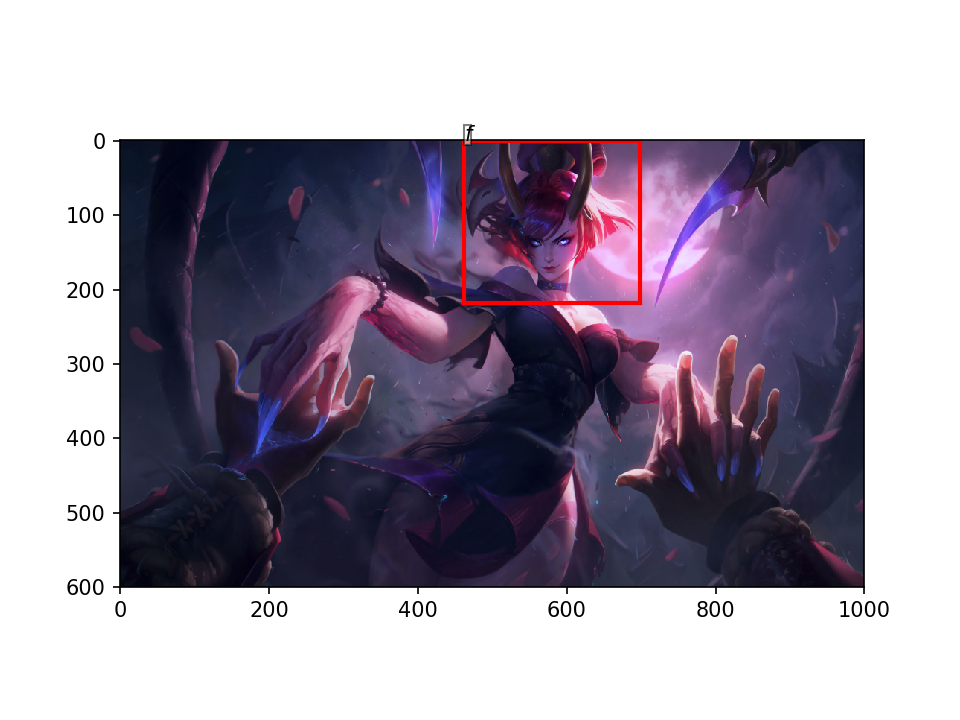

In [187]:
vis_train(img,bbox,label)

In [188]:
img, bbox, label = img.cuda().float(), bbox.cuda(), label.cuda()

In [189]:
img.shape

torch.Size([1, 3, 600, 1000])

In [190]:
trainer.optimizer.zero_grad()

In [191]:
img_size = img.shape[2:4]
features = trainer.faster_rcnn.extractor(img)

In [192]:
img_size

torch.Size([600, 1000])

In [193]:
features.shape

torch.Size([1, 512, 37, 62])

In [194]:
rpn_locs, rpn_scores, rois, roi_indices, anchor = trainer.faster_rcnn.rpn(features, img_size)

In [195]:
print(rpn_locs.shape)
print(rpn_scores.shape)
print(rois.shape)
print(roi_indices.shape)
print(anchor.shape)

torch.Size([1, 20646, 4])
torch.Size([1, 20646, 2])
(1686, 4)
(1686,)
(20646, 4)


In [196]:
bbox = bbox[0]
label = label[0]
rpn_score = rpn_scores[0]
rpn_loc = rpn_locs[0]
roi = rois

In [197]:
img_show = img.cpu()

In [198]:
img_show.shape

torch.Size([1, 3, 600, 1000])

<IPython.core.display.Javascript object>


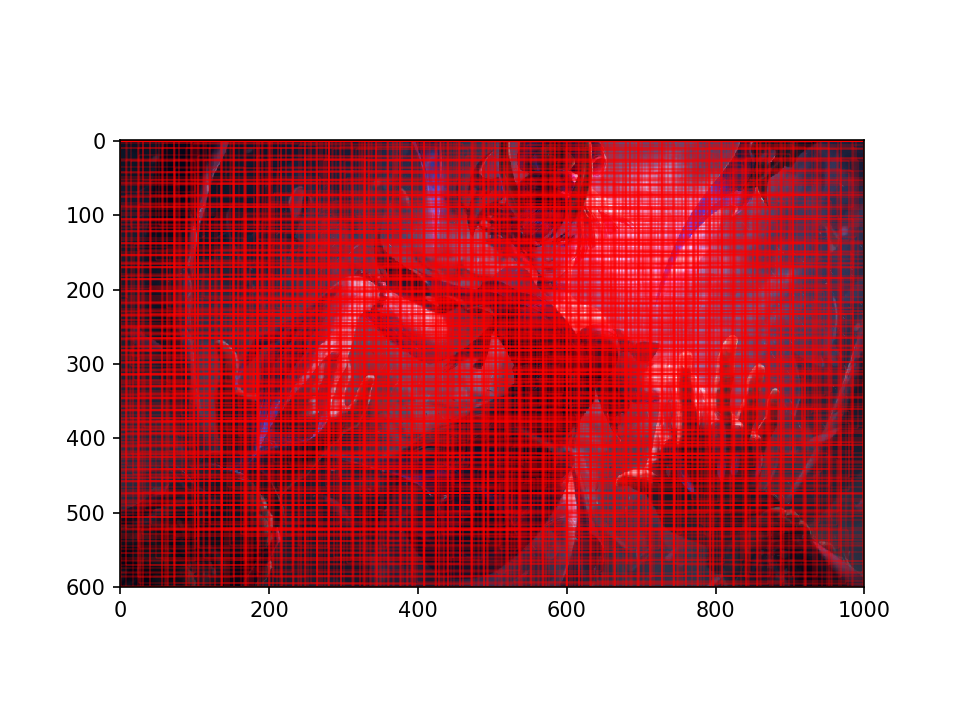

In [199]:
img = inverse_normalize(img_show[0].numpy())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = img.transpose((1, 2, 0))
ax.imshow(img.astype(np.uint8))

for i in range(len(rois)):
    y1 = rois[i][0]
    x1 = rois[i][1]
    y2 = rois[i][2]
    x2 = rois[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.2))

In [200]:
sample_roi, gt_roi_loc, gt_roi_label, keep_index = trainer.proposal_target_creator(
            roi,
            at.tonumpy(bbox),
            at.tonumpy(label),
            trainer.loc_normalize_mean,
            trainer.loc_normalize_std)

In [201]:
print(sample_roi.shape)
print(gt_roi_loc.shape)
print(gt_roi_label.shape)
print(keep_index.shape)

(128, 4)
(128, 4)
(128,)
(128,)


<IPython.core.display.Javascript object>


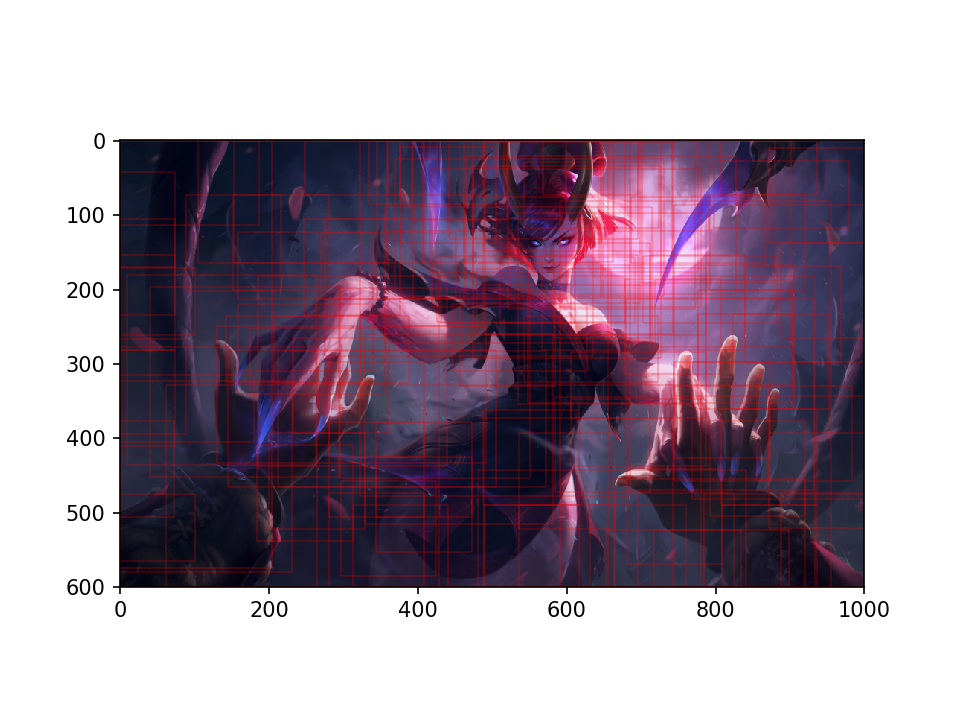

In [202]:
img = inverse_normalize(img_show[0].numpy())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = img.transpose((1, 2, 0))
ax.imshow(img.astype(np.uint8))

for i in range(len(sample_roi)):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.2))

In [34]:
def show():
    img, bbox, label = next(iter(dataloader))
    vis_train(img,bbox,label)
    img, bbox, label = img.cuda().float(), bbox.cuda(), label.cuda()
    img_size = img.shape[2:4]
    features = trainer.faster_rcnn.extractor(img)
    rpn_locs, rpn_scores, rois, roi_indices, anchor = trainer.faster_rcnn.rpn(features, img_size)
    
    bbox = bbox[0]
    label = label[0]
    rpn_score = rpn_scores[0]
    rpn_loc = rpn_locs[0]
    roi = rois
    img_show = img.cpu()
    
    img = inverse_normalize(img_show[0].numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))

    for i in range(len(rois)):
        y1 = rois[i][0]
        x1 = rois[i][1]
        y2 = rois[i][2]
        x2 = rois[i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.2))
    
    sample_roi, gt_roi_loc, gt_roi_label, keep_index = trainer.proposal_target_creator(
            roi,
            at.tonumpy(bbox),
            at.tonumpy(label),
            trainer.loc_normalize_mean,
            trainer.loc_normalize_std)
    
    img = inverse_normalize(img_show[0].numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))

    for i in range(len(sample_roi)):
        y1 = sample_roi[i][0]
        x1 = sample_roi[i][1]
        y2 = sample_roi[i][2]
        x2 = sample_roi[i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.2))

In [39]:
opt._parse({})

print('load data')
dataset = Dataset(opt)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

faster_rcnn = FasterRCNNVGG16()
print('model construct completed')

trainer = FasterRCNNTrainer(faster_rcnn).cuda()

lr_ = opt.lr

def train():

    for epoch in range(20):
        print(epoch)
        
        if epoch%2 ==0:
            print(trainer.get_meter_data())
        
        trainer.reset_meters()
        for ii, (img, bbox_, label_) in enumerate(dataloader):
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            trainer.train_step(img, bbox, label)

        lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
        log_info = 'lr:{},loss:{}'.format(str(lr_), str(trainer.get_meter_data()))

        if epoch == 10:
            trainer.faster_rcnn.scale_lr(opt.lr_decay)
            lr_ = lr_ * opt.lr_decay

        

======user config========
{'voc_data_dir': 'C:/Users/62307/Desktop/faster-rcnn-keras/VOCdevkit/VOC2007/', 'rpn_sigma': 3.0, 'roi_sigma': 1.0, 'weight_decay': 0.0005, 'lr_decay': 0.1, 'lr': 0.001, 'data': 'voc', 'pretrained_model': 'vgg16', 'debug_file': '/tmp/debugf'}
==========end============
load data
model construct completed


In [147]:
train()

0
{'rpn_loc_loss': 0.008866047798619549, 'rpn_cls_loss': 0.0956819511193316, 'roi_loc_loss': 0.17628805761160038, 'roi_cls_loss': 0.14512437907978892, 'total_loss': 0.4259604333201422}
1
2
{'rpn_loc_loss': 0.008707769894044757, 'rpn_cls_loss': 0.09022456209640949, 'roi_loc_loss': 0.08612627272395915, 'roi_cls_loss': 0.11511008883826435, 'total_loss': 0.3001686923671514}
3
4
{'rpn_loc_loss': 0.0084751644667449, 'rpn_cls_loss': 0.08870728427427825, 'roi_loc_loss': 0.08861998841166496, 'roi_cls_loss': 0.12068939860910176, 'total_loss': 0.3064918344607578}
5
6
{'rpn_loc_loss': 0.008476089350097023, 'rpn_cls_loss': 0.0862494987959508, 'roi_loc_loss': 0.09477449709856955, 'roi_cls_loss': 0.12404159680590965, 'total_loss': 0.3135416817385702}
7
8
{'rpn_loc_loss': 0.008499687719222493, 'rpn_cls_loss': 0.08561964632826857, 'roi_loc_loss': 0.09850339550484932, 'roi_cls_loss': 0.12390813749516393, 'total_loss': 0.3165308668976649}
9
10
{'rpn_loc_loss': 0.008428963286405633, 'rpn_cls_loss': 0.0824

In [131]:
img, bbox, label = next(iter(dataloader))
img, bbox, label = img.cuda().float(), bbox.cuda(), label.cuda()
img_size = img.shape[2:4]

In [132]:
roi_cls_loc, roi_scores, rois, _ = trainer.faster_rcnn(img)

In [133]:
roi_score = roi_scores.data
roi_cls_loc = roi_cls_loc.data
roi = at.totensor(rois)

print(roi_score.shape, roi_cls_loc.shape, roi.shape)

torch.Size([300, 2]) torch.Size([300, 8]) torch.Size([300, 4])


In [134]:
mean = t.Tensor(trainer.faster_rcnn.loc_normalize_mean).cuda().repeat(trainer.faster_rcnn.n_class)[None]
std = t.Tensor(trainer.faster_rcnn.loc_normalize_std).cuda().repeat(trainer.faster_rcnn.n_class)[None]

In [135]:
roi_cls_loc = (roi_cls_loc * std + mean)

In [136]:
roi_cls_loc = roi_cls_loc.view(-1, trainer.faster_rcnn.n_class, 4)
print(roi_cls_loc.shape)

torch.Size([300, 2, 4])


In [137]:
roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
print(roi.shape)

torch.Size([300, 2, 4])


In [138]:
cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)), at.tonumpy(roi_cls_loc).reshape((-1, 4)))
cls_bbox = at.totensor(cls_bbox)
cls_bbox = cls_bbox.view(-1, trainer.faster_rcnn.n_class * 4)

In [139]:
print(cls_bbox.shape)

torch.Size([300, 8])


In [140]:
# clip bounding box
cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=600)
cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=1000)

In [141]:
prob = at.tonumpy(F.softmax(at.totensor(roi_score), dim=1))
print(prob.shape)

(300, 2)


In [142]:
raw_cls_bbox = at.tonumpy(cls_bbox)
raw_prob = at.tonumpy(prob)
bbox, label, score = trainer.faster_rcnn._suppress(raw_cls_bbox, raw_prob)

In [143]:
print(bbox.shape)
print(label.shape)
print(score.shape)

(8, 4)
(8,)
(8,)


<IPython.core.display.Javascript object>


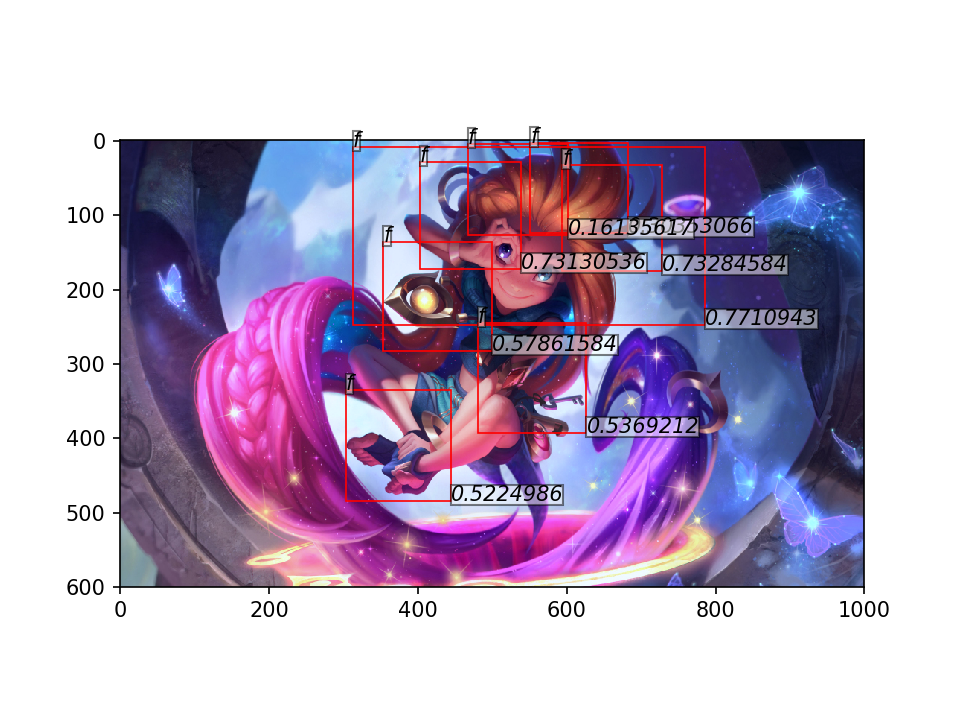

In [144]:
img_show = img.cpu()
img = inverse_normalize(img_show[0].numpy())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = img.transpose((1, 2, 0))
ax.imshow(img.astype(np.uint8))

for i in range(len(bbox)):
    y1 = bbox[i][0]
    x1 = bbox[i][1]
    y2 = bbox[i][2]
    x2 = bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.8))
    ax.text(x1,y1,BBOX_LABEL_NAMES[label[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    ax.text(x2,y2,score[i],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

In [149]:
def predict():
    img, bbox, label = next(iter(dataloader))
    img, bbox, label = img.cuda().float(), bbox.cuda(), label.cuda()
    img_size = img.shape[2:4]
    roi_cls_loc, roi_scores, rois, _ = trainer.faster_rcnn(img)
    roi_score = roi_scores.data
    roi_cls_loc = roi_cls_loc.data
    roi = at.totensor(rois)
    
    mean = t.Tensor(trainer.faster_rcnn.loc_normalize_mean).cuda().repeat(trainer.faster_rcnn.n_class)[None]
    std = t.Tensor(trainer.faster_rcnn.loc_normalize_std).cuda().repeat(trainer.faster_rcnn.n_class)[None]
    roi_cls_loc = (roi_cls_loc * std + mean)
    roi_cls_loc = roi_cls_loc.view(-1, trainer.faster_rcnn.n_class, 4)
    roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
    cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)), at.tonumpy(roi_cls_loc).reshape((-1, 4)))
    cls_bbox = at.totensor(cls_bbox)
    cls_bbox = cls_bbox.view(-1, trainer.faster_rcnn.n_class * 4)
    cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=600)
    cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=1000)
    prob = at.tonumpy(F.softmax(at.totensor(roi_score), dim=1))
    raw_cls_bbox = at.tonumpy(cls_bbox)
    raw_prob = at.tonumpy(prob)
    bbox, label, score = trainer.faster_rcnn._suppress(raw_cls_bbox, raw_prob)
    
    keep_idx = score > 0.5
    bbox = bbox[keep_idx]
    label = label[keep_idx]
    score = score[keep_idx]

    img_show = img.cpu()
    img = inverse_normalize(img_show[0].numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))

    for i in range(len(bbox)):
        y1 = bbox[i][0]
        x1 = bbox[i][1]
        y2 = bbox[i][2]
        x2 = bbox[i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=0.8))
        ax.text(x1,y1,BBOX_LABEL_NAMES[label[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
        ax.text(x2,y2,score[i],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

<IPython.core.display.Javascript object>


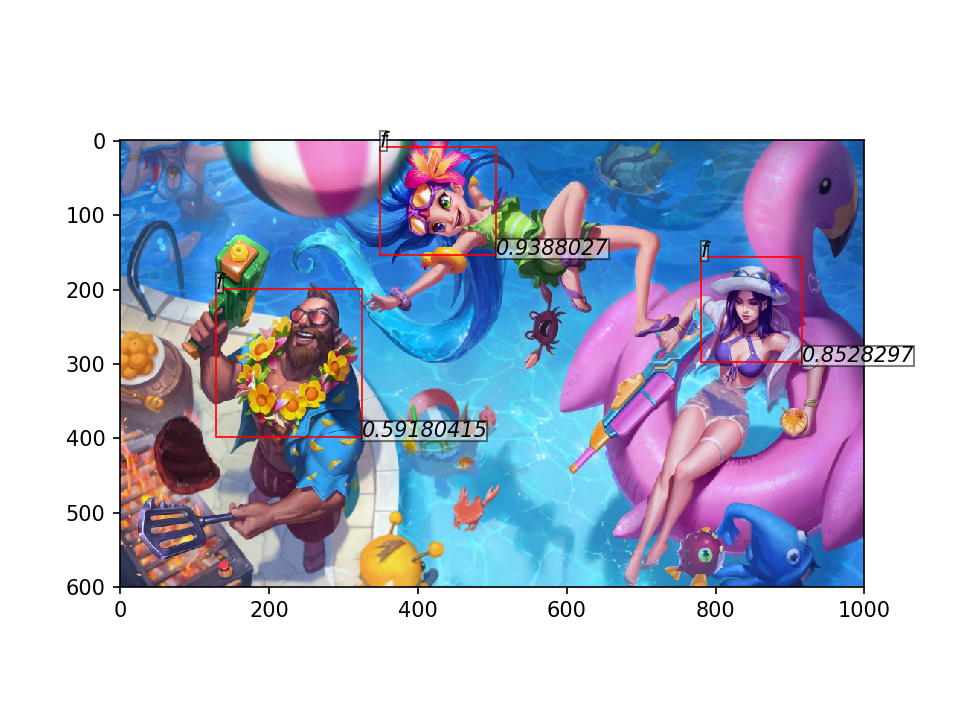

In [199]:
predict()